### Monte Carlo Release-Recapture Temperatures

In [1]:
using BeamPropagation, 
    Distributions, 
    UnitsToValue,
    StatsBase, 
    StaticArrays, 
    Plots,
    StructArrays,
    MutableNamedTuples,
    PhysicalConstants.CODATA2018,
    LinearAlgebra

In [2]:
# Define physical constants
const kB = BoltzmannConstant.val
const T = @with_unit 30 "μK"

# Define molecule parameters for CaOH
const m = @with_unit 57 "u"
const v_recoil = @with_unit 1.1 "cm/s"
;

In [3]:
# Define tweezer beam properties
const T_depth = @with_unit 1.4 "mK"
const U_max = kB * T_depth
const λ = 780e-9
const w0x = 2.0e-6
const w0y = 2.0e-6

# Create an instance of a gaussian trap for the tweezer
trap = AsymmetricGaussianTrap(λ=λ, w0x=w0x, w0y=w0y, U_max=U_max, m=m)
;

In [4]:
total_time = @with_unit 5000 "μs"               
release_start_time = @with_unit 2000 "μs"        
release_end_time = @with_unit 2020 "μs"         
;

In [5]:
n = 5000
save_every = 100
delete_every = 50
dt_min = 1e-10
dt_max = 1e-4
abstol = 1e-5
dt = 1e-7
max_steps = Int64(ceil(total_time / dt))
alg = "rkf12"
use_adaptive = false
dt0 = 1e-5
times = (0:dt:max_steps * dt)[1:save_every:end-1]
;

In [6]:
discard(r, v) = false
is_detectable(r, trap) = (abs(r[1]) < 5trap.w0x) && (abs(r[2]) < 5trap.w0y) && (abs(r[3]) < 5max(trap.zRx, trap.zRy))

function update(particles, p, s, dt, time, idx)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        r = particles.r[i]
        s.detectable[idx] = is_detectable(r, p.trap)
    end
    return nothing
end

gravity(r) = SVector(0.0, -9.81, 0.0)

function f(idx, r, v, p, time)
    if p.release_start_time < time < p.release_end_time
        U_depth = 0.0
    else
        U_depth = p.trap.U_max
    end
    return F(r, p.trap) * U_depth / m + gravity(r)
end

function save(particles, p, s)
    for i in 1:size(particles, 1)
        idx = particles.idx[i]
        push!(s.trajectories[idx], particles.r[i])
    end
    return nothing
end
;

In [7]:
detectable = zeros(Bool, n)

particles = StructArray{Particle}(undef, n)
trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]

r, v, a = make_distributions(T, trap)

p = @params (trap, release_start_time, release_end_time)
s = @params (detectable, trajectories)

@time propagate_particles!(r, v, a, 
    alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
    dt_min, dt_max, abstol, true
)
mean(s.detectable) |> display

  4.607533 seconds (1.56 M allocations: 210.869 MiB, 0.59% gc time, 189.54% compilation time)


0.8362

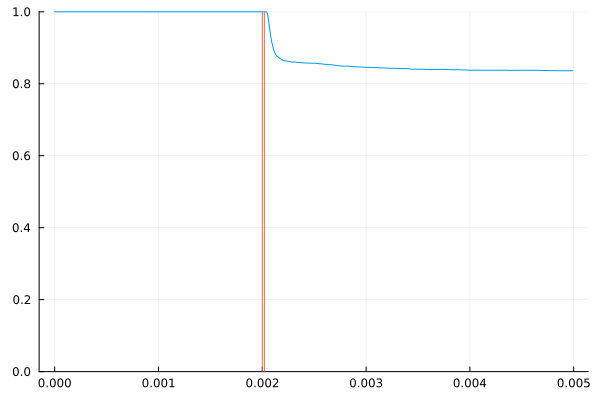

In [8]:
survival = vec(mean(mapreduce(permutedims, vcat, [[is_detectable(s.trajectories[i][j], trap) for j ∈ 1:length(times)] for i ∈ 1:n]), dims=1))
plot(times, survival, legend=nothing)
plot!(ylim=(0,1))
vline!([release_start_time, release_end_time])

## Scan in-trap temperature to fit to data

In [33]:
data_xs = 1e-6 .* [
    2
    4
    6
    8
    10
    12
    14
    20
    24
    30
    34
    35
    40
    50
]

data_ys = [
    0.570110701107011
    0.573214285714286
    0.57037037037037
    0.498525073746313
    0.362459546925566
    0.347692307692308
    0.315112540192926
    0.245901639344262
    0.157556270096463
    0.127877237851662
    0.139705882352941
    0.0786516853932584
    0.133333333333333
    0.0846394984326019
]
;

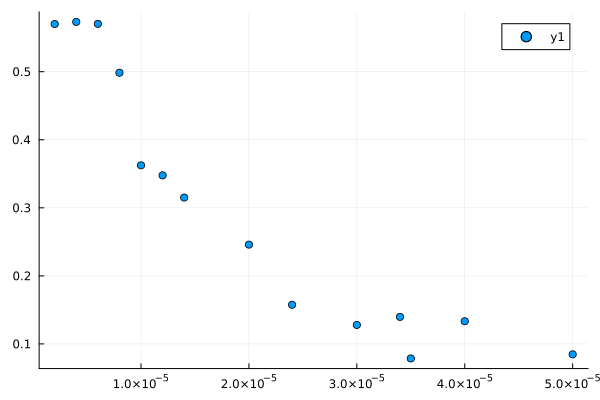

In [34]:
scatter(data_xs, data_ys)

In [35]:
# Create a release-recapture plot for a single temperature
const T = T_depth / 10;
r, v, a = make_distributions(T, trap)
release_durations = deepcopy(data_xs)

surviving_fractions = zeros(length(release_durations))
for (i, release_duration) ∈ enumerate(release_durations)

    # Reset parameters for current run
    p.release_start_time = release_start_time
    p.release_end_time = release_start_time + release_duration
    
    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    surviving_fractions[i] = mean(s.detectable)
end

  3.667667 seconds (20.39 k allocations: 108.692 MiB)
  3.924558 seconds (20.52 k allocations: 108.703 MiB)
  3.630889 seconds (20.52 k allocations: 108.703 MiB)
  3.764213 seconds (20.63 k allocations: 108.712 MiB)
  5.936976 seconds (20.55 k allocations: 108.703 MiB, 5.29% gc time)
  3.958207 seconds (20.53 k allocations: 108.703 MiB)
  4.174929 seconds (20.53 k allocations: 108.703 MiB)
  4.215200 seconds (20.53 k allocations: 108.703 MiB)
  4.176790 seconds (20.65 k allocations: 108.713 MiB)
  4.348035 seconds (20.66 k allocations: 108.713 MiB)
  5.178166 seconds (20.53 k allocations: 108.703 MiB, 16.17% gc time)
  3.951516 seconds (20.53 k allocations: 108.703 MiB)
  3.930087 seconds (20.52 k allocations: 108.703 MiB)
  4.042383 seconds (20.53 k allocations: 108.703 MiB)


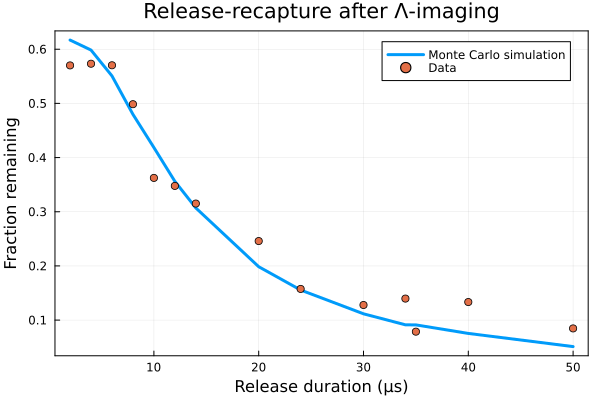

In [36]:
plot(release_durations .* 1e6, 0.62 * surviving_fractions,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [46]:
ηs = 6:15
Ts = T_depth ./ ηs

release_durations = data_xs
surviving_fractions = Vector{Float64}[]

iter = Ts
for (i, T) ∈ enumerate(Ts)
    display(ηs[i])
    r, v, a = make_distributions(T, trap)
    surviving_fraction = zeros(length(release_durations))

    for (j, release_duration) ∈ enumerate(release_durations)

        # Reset parameters for current run
        p.release_start_time = release_start_time
        p.release_end_time = release_start_time + release_duration

        particles = StructArray{Particle}(undef, n)
        detectable = zeros(Bool, n)
        trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
        s = @params (detectable, trajectories)

        @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
            dt_min, dt_max, abstol, true)

        surviving_fraction[j] = mean(s.detectable)
        
    end
    push!(surviving_fractions, surviving_fraction) 
end

6

  3.761883 seconds (20.39 k allocations: 108.692 MiB)
  3.878014 seconds (20.52 k allocations: 108.703 MiB)
  4.058067 seconds (20.52 k allocations: 108.703 MiB)
  3.940739 seconds (20.53 k allocations: 108.703 MiB)
  4.934002 seconds (20.54 k allocations: 108.703 MiB, 3.91% gc time)
  3.999200 seconds (20.52 k allocations: 108.703 MiB)
  4.186338 seconds (20.54 k allocations: 108.703 MiB)
  3.947198 seconds (20.52 k allocations: 108.703 MiB)
  3.999954 seconds (20.52 k allocations: 108.703 MiB)
  3.926808 seconds (20.52 k allocations: 108.703 MiB)
  6.481131 seconds (20.56 k allocations: 108.703 MiB, 11.70% gc time)
  4.023589 seconds (20.64 k allocations: 108.713 MiB)
  3.940704 seconds (20.52 k allocations: 108.703 MiB)
  4.078891 seconds (20.64 k allocations: 108.713 MiB)


7

  3.758593 seconds (20.39 k allocations: 108.692 MiB)
  3.784759 seconds (20.52 k allocations: 108.703 MiB)
  6.417813 seconds (20.55 k allocations: 108.703 MiB, 12.70% gc time)
  3.907434 seconds (20.52 k allocations: 108.703 MiB)
  3.892215 seconds (20.52 k allocations: 108.703 MiB)
  3.937880 seconds (20.52 k allocations: 108.703 MiB)
  3.956123 seconds (20.64 k allocations: 108.713 MiB)
  3.972711 seconds (20.52 k allocations: 108.703 MiB)
  3.859540 seconds (20.51 k allocations: 108.703 MiB)
  5.609286 seconds (20.54 k allocations: 108.703 MiB, 14.79% gc time)
  3.970417 seconds (20.52 k allocations: 108.703 MiB)
  4.076984 seconds (20.51 k allocations: 108.702 MiB)
  3.946927 seconds (20.52 k allocations: 108.703 MiB)
  3.973391 seconds (20.64 k allocations: 108.713 MiB)


8

  3.715650 seconds (20.40 k allocations: 108.693 MiB)
  6.132711 seconds (20.55 k allocations: 108.703 MiB, 5.67% gc time)
  3.874974 seconds (20.52 k allocations: 108.703 MiB)
  3.939792 seconds (20.52 k allocations: 108.703 MiB)
  3.879238 seconds (20.51 k allocations: 108.702 MiB)
  4.098052 seconds (20.52 k allocations: 108.703 MiB)
  4.216384 seconds (20.53 k allocations: 108.703 MiB)
  4.036511 seconds (20.52 k allocations: 108.703 MiB)
  4.344211 seconds (20.65 k allocations: 108.713 MiB)
  4.343076 seconds (20.54 k allocations: 108.703 MiB)
  4.117668 seconds (20.52 k allocations: 108.703 MiB)
  4.170168 seconds (20.53 k allocations: 108.703 MiB)
  4.335099 seconds (20.53 k allocations: 108.703 MiB)
  4.042762 seconds (20.52 k allocations: 108.703 MiB)


9

  5.952149 seconds (20.42 k allocations: 108.693 MiB, 8.77% gc time)
  3.856962 seconds (20.53 k allocations: 108.703 MiB)
  3.948075 seconds (20.53 k allocations: 108.703 MiB)
  3.956110 seconds (20.52 k allocations: 108.703 MiB)
  4.266354 seconds (20.53 k allocations: 108.703 MiB)
  4.267091 seconds (20.53 k allocations: 108.703 MiB)
  6.461176 seconds (20.54 k allocations: 108.703 MiB, 6.30% gc time)
  4.077583 seconds (20.52 k allocations: 108.703 MiB)
  4.247966 seconds (20.53 k allocations: 108.703 MiB)
  3.979944 seconds (20.52 k allocations: 108.703 MiB)
  4.205307 seconds (20.53 k allocations: 108.703 MiB)
  4.288744 seconds (20.52 k allocations: 108.703 MiB)
  4.081085 seconds (20.52 k allocations: 108.703 MiB)
  4.007182 seconds (20.64 k allocations: 108.712 MiB)


10

  3.759956 seconds (20.40 k allocations: 108.693 MiB)
  3.889923 seconds (20.52 k allocations: 108.703 MiB)
  4.040359 seconds (20.53 k allocations: 108.703 MiB)
  3.935484 seconds (20.51 k allocations: 108.703 MiB)
  4.075820 seconds (20.53 k allocations: 108.703 MiB)
  4.966556 seconds (20.52 k allocations: 108.703 MiB, 15.34% gc time)
  4.156926 seconds (20.53 k allocations: 108.703 MiB)
  4.140636 seconds (20.52 k allocations: 108.703 MiB)
  4.110296 seconds (20.52 k allocations: 108.703 MiB)
  4.012490 seconds (20.52 k allocations: 108.703 MiB)
  4.168107 seconds (20.53 k allocations: 108.703 MiB)
  6.505762 seconds (20.56 k allocations: 108.703 MiB, 11.79% gc time)
  4.055250 seconds (20.52 k allocations: 108.703 MiB)
  4.036678 seconds (20.52 k allocations: 108.703 MiB)


11

  3.741390 seconds (20.40 k allocations: 108.693 MiB)
  4.044606 seconds (20.53 k allocations: 108.703 MiB)
  3.882648 seconds (20.52 k allocations: 108.703 MiB)
  3.950737 seconds (20.52 k allocations: 108.703 MiB)
  5.623420 seconds (20.53 k allocations: 108.703 MiB, 13.06% gc time)
  4.229706 seconds (20.53 k allocations: 108.703 MiB)
  3.851874 seconds (20.51 k allocations: 108.703 MiB)
  3.974075 seconds (20.52 k allocations: 108.703 MiB)
  3.878499 seconds (20.51 k allocations: 108.703 MiB)
  3.961298 seconds (20.53 k allocations: 108.703 MiB)
  6.047718 seconds (20.55 k allocations: 108.703 MiB, 8.09% gc time)
  4.193646 seconds (20.64 k allocations: 108.713 MiB)
  3.883029 seconds (20.52 k allocations: 108.703 MiB)
  3.813978 seconds (20.51 k allocations: 108.703 MiB)


12

  3.733643 seconds (20.40 k allocations: 108.692 MiB)
  3.742474 seconds (20.64 k allocations: 108.713 MiB)
  6.021041 seconds (20.55 k allocations: 108.703 MiB, 8.98% gc time)
  3.763369 seconds (20.52 k allocations: 108.703 MiB)
  3.906483 seconds (20.52 k allocations: 108.703 MiB)
  3.950777 seconds (20.53 k allocations: 108.703 MiB)
  4.119959 seconds (20.52 k allocations: 108.703 MiB)
  4.173935 seconds (20.65 k allocations: 108.713 MiB)
  4.080962 seconds (20.52 k allocations: 108.703 MiB)
  5.930129 seconds (20.55 k allocations: 108.704 MiB, 13.58% gc time)
  4.134822 seconds (20.53 k allocations: 108.703 MiB)
  4.318774 seconds (20.53 k allocations: 108.703 MiB)
  4.229862 seconds (20.53 k allocations: 108.703 MiB)
  4.089282 seconds (20.52 k allocations: 108.703 MiB)


13

  3.789703 seconds (20.39 k allocations: 108.692 MiB)
  4.332896 seconds (20.52 k allocations: 108.703 MiB, 7.35% gc time)
  3.900978 seconds (20.53 k allocations: 108.703 MiB)
  3.961459 seconds (20.53 k allocations: 108.703 MiB)
  4.070234 seconds (20.64 k allocations: 108.713 MiB)
  3.994105 seconds (20.52 k allocations: 108.703 MiB)
  4.043825 seconds (20.53 k allocations: 108.703 MiB)
  4.125441 seconds (20.52 k allocations: 108.703 MiB)
  3.909454 seconds (20.64 k allocations: 108.713 MiB)
  4.033435 seconds (20.52 k allocations: 108.703 MiB)
  4.225325 seconds (20.53 k allocations: 108.703 MiB)
  4.158248 seconds (20.52 k allocations: 108.703 MiB)
  4.083558 seconds (20.51 k allocations: 108.703 MiB)
  4.011507 seconds (20.52 k allocations: 108.703 MiB)


14

  5.657067 seconds (20.43 k allocations: 108.693 MiB, 7.46% gc time)
  3.994306 seconds (20.52 k allocations: 108.703 MiB)
  3.989379 seconds (20.52 k allocations: 108.703 MiB)
  4.021107 seconds (20.53 k allocations: 108.703 MiB)
  3.938141 seconds (20.52 k allocations: 108.703 MiB)
  3.934202 seconds (20.52 k allocations: 108.703 MiB)
  5.953574 seconds (20.54 k allocations: 108.703 MiB, 8.23% gc time)
  4.116636 seconds (20.64 k allocations: 108.713 MiB)
  4.139807 seconds (20.52 k allocations: 108.702 MiB)
  4.207533 seconds (20.52 k allocations: 108.703 MiB)
  3.971957 seconds (20.52 k allocations: 108.703 MiB)
  4.181341 seconds (20.52 k allocations: 108.703 MiB)
  4.036554 seconds (20.63 k allocations: 108.712 MiB)
  4.783038 seconds (20.64 k allocations: 108.713 MiB, 12.10% gc time)


15

  3.877681 seconds (20.40 k allocations: 108.692 MiB)
  3.946730 seconds (20.53 k allocations: 108.703 MiB)
  3.965587 seconds (20.53 k allocations: 108.703 MiB)
  3.992312 seconds (20.52 k allocations: 108.703 MiB)
  4.053252 seconds (20.53 k allocations: 108.703 MiB)
  4.412524 seconds (20.52 k allocations: 108.703 MiB, 12.51% gc time)
  4.000548 seconds (20.52 k allocations: 108.703 MiB)
  4.018517 seconds (20.52 k allocations: 108.703 MiB)
  3.922635 seconds (20.52 k allocations: 108.703 MiB)
  4.126220 seconds (20.52 k allocations: 108.703 MiB)
  4.362710 seconds (20.53 k allocations: 108.703 MiB)
  6.897135 seconds (20.55 k allocations: 108.703 MiB, 14.37% gc time)
  3.976766 seconds (20.52 k allocations: 108.703 MiB)
  4.069488 seconds (20.64 k allocations: 108.712 MiB)


In [54]:
χ²(data, preds) = sum((data .- preds).^2 ./ 0.04^2);

In [55]:
function model_with_best_scaling(data_ys, model_ys)
    min_error = Inf
    best_scaling = 1.0 
    for scaling ∈ 0.1:0.01:5.0
        error = χ²(data_ys, model_ys .* scaling)
        if error < min_error
            min_error = error
            best_scaling = scaling
        end
    end
    println(best_scaling)
    return model_ys .* best_scaling
end

model_with_best_scaling (generic function with 1 method)

In [56]:
χ²_errors = [
    χ²(
        data_ys,
        model_with_best_scaling(data_ys, surviving_fractions[i])
        )
    for i ∈ 1:size(surviving_fractions, 1)]
;

0.72
0.68
0.65
0.63
0.61
0.59
0.58
0.57
0.56
0.55


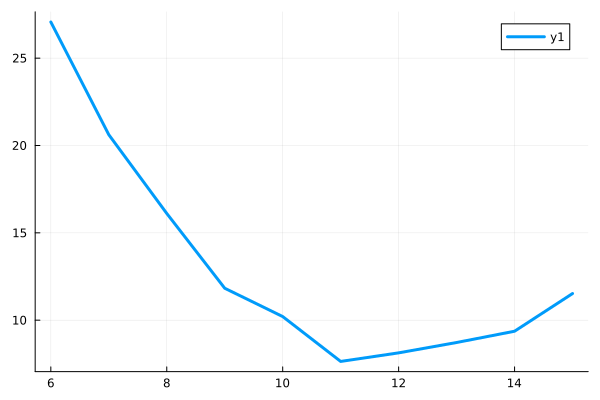

In [57]:
plot(T_depth ./ Ts, χ²_errors,
    linewidth=3,
    )

In [58]:
# χ²_errors_1 = deepcopy(χ²_errors)
# χ²_errors_2 = deepcopy(χ²_errors)
# χ²_errors_3 = deepcopy(χ²_errors)
# χ²_errors_4 = deepcopy(χ²_errors)

In [59]:
plot(T_depth ./ Ts, χ²_errors_1,
    linewidth=3,
    xlabel="η",
    ylabel="χ² error",
    label="SF cooling",
    box=:on,
    title="χ² errors vs. η for release-recapture data" 
    )
plot!(T_depth ./ Ts, χ²_errors_2,
    linewidth=3,
    label="SF cooling, (100) slowing repumper off"
    )
plot!(T_depth ./ Ts, χ²_errors_3,
    linewidth=3,
    label="SF cooling, tweezer intensity PID off"
    )
plot!(T_depth ./ Ts, χ²_errors_4,
    linewidth=3,
    label="Lambda cooling"
    )

LoadError: UndefVarError: `χ²_errors_1` not defined

0.00012727272727272728

0.59


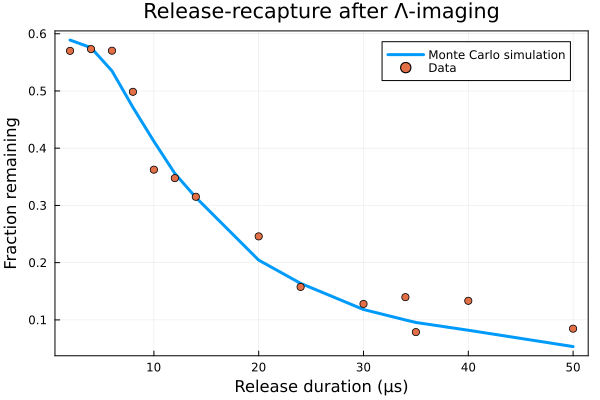

In [60]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [69]:
best_preds

14-element Vector{Float64}:
 0.588938
 0.575604
 0.535012
 0.47129199999999993
 0.411938
 0.35577
 0.313998
 0.20437599999999997
 0.163784
 0.11811799999999999
 0.09982799999999999
 0.09546199999999999
 0.081892
 0.053335999999999995

In [61]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds_75,
    title="Release-recapture after Λ-imaging",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
plot!(release_durations .* 1e6, best_preds_83, linewidth=3, label="Monte Carlo simulation")
plot!(release_durations .* 1e6, best_preds_90, linewidth=3, label="Monte Carlo simulation")
scatter!(data_xs_75 .* 1e6, data_ys_75, label="Data (7.5 V detuning)")
scatter!(data_xs_83 .* 1e6, data_ys_83, label="Data (8.3 V detuning)")
scatter!(data_xs_90 .* 1e6, data_ys_90, label="Data (9.0 V detuning)")

0.00012727272727272728

0.59


LoadError: UndefVarError: `best_preds_75` not defined

In [62]:
data_xs_90 = deepcopy(data_xs)
data_ys_90 = deepcopy(data_ys)
best_preds_90 = deepcopy(best_preds)
;

In [63]:
# data_xs_75 = deepcopy(data_xs)
# data_ys_75 = deepcopy(data_ys)
# best_preds_75 = deepcopy(best_preds)
# ;

In [64]:
# data_xs_83 = deepcopy(data_xs)
# data_ys_83 = deepcopy(data_ys)
# best_preds_83 = deepcopy(best_preds)
# ;

0.00012727272727272728

0.59


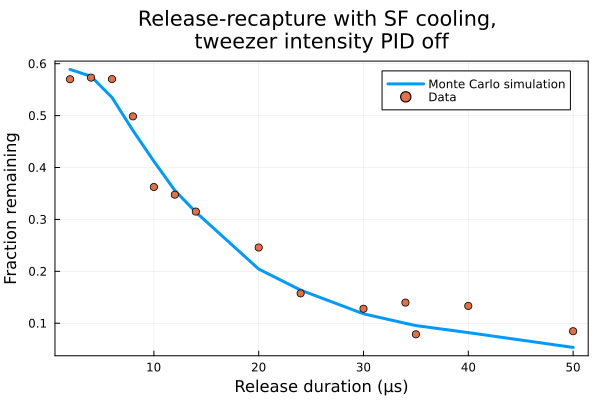

In [65]:
min_error, best_idx = findmin(χ²_errors)
Ts[best_idx] |> display
best_preds = model_with_best_scaling(data_ys, surviving_fractions[best_idx])

plot(release_durations .* 1e6, best_preds,
    title="Release-recapture with SF cooling, \n tweezer intensity PID off \n",
    linewidth=3,
    box=:on,
    label="Monte Carlo simulation",
    xlabel="Release duration (μs)",
    ylabel="Fraction remaining"
)
scatter!(data_xs  .* 1e6, data_ys, label="Data")

In [66]:
using LsqFit
@. model(T, p) = p[1] * (T - p[2])^2 + p[3]

model (generic function with 1 method)

3-element Vector{Float64}:
  0.5130686526148326
 12.09002329723469
  7.592472907704866

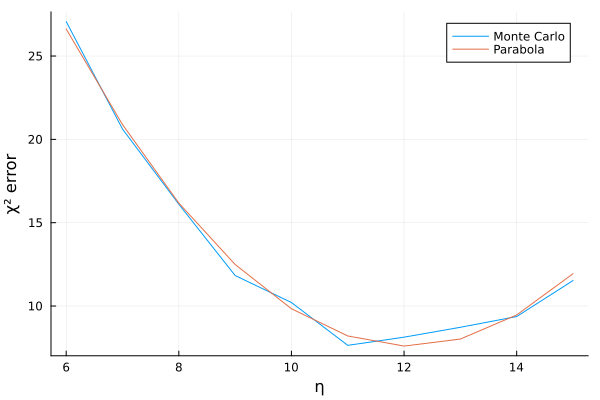

In [67]:
x = 0
y = 0

lb = [0, 0.0, 0.]
p0 = [0., 8, 0.]
ub = [1.0, 20, 20.0]
fitted_model = curve_fit(model, ηs[x+1:end-y], χ²_errors[x+1:end-y], p0, lower=lb, upper=ub)
display(fitted_model.param)
plot(ηs[x+1:end-y], χ²_errors[x+1:end-y], label="Monte Carlo", xlabel="η", ylabel="χ² error")
plot!(ηs[x+1:end-y], model(ηs[x+1:end-y], fitted_model.param), label="Parabola")

In [70]:
# The second derivative with respect to T is given by
sqrt(2 * (2fitted_model.param[1])^(-1))

1.3960862812770702

### Bootstrap model outputs to get an error range

In [ ]:
surviving_fractions

In [24]:
n = 2_000
T = 60e-6
r, v, a = make_distributions(T)

simul_xs = collect(shaved_U_depth_ratios[1]:0.01:shaved_U_depth_ratios[end])

detectable_all = zeros(n, length(simul_xs))

for (j, shaved_U_depth_ratio) ∈ enumerate(simul_xs)
    shaved_U_depth = original_U_depth * shaved_U_depth_ratio

    # Reset parameters for current run
    p.time = 0.0
    p.shaved_U_depth = shaved_U_depth

    particles = StructArray{Particle}(undef, n)
    detectable = zeros(Bool, n)
    trajectories = [SVector{3, Float64}[] for _ ∈ 1:length(particles)]
    s = @params (detectable, trajectories)

    @time propagate_particles!(r, v, a, alg, particles, f, save, discard, save_every, delete_every, max_steps, update, p, s, dt, use_adaptive, 
        dt_min, dt_max, abstol, true)

    detectable_all[:,j] .= s.detectable
    
end

LoadError: MethodError: no method matching make_distributions(::Float64)

[0mClosest candidates are:
[0m  make_distributions(::Any, [91m::AsymmetricGaussianTrap[39m)
[0m[90m   @[39m [36mBeamPropagation[39m [90mC:\Google Drive\github\BeamPropagation\src\[39m[90m[4mAsymmetricGaussianTrap.jl:54[24m[39m


In [25]:
n_bootstraps = 10000

surviving_fractions_lower = zeros(length(simul_xs))
surviving_fractions_upper = zeros(length(simul_xs))

for i ∈ eachindex(simul_xs)
    bootstrap_idxs = rand(1:n, n, n_bootstraps)
    bootstrap_samples = detectable_all[:,i][bootstrap_idxs]
    bootstrap_means = vec(mean(bootstrap_samples, dims=1))
    surviving_fractions_lower[i] = percentile(bootstrap_means, 50 - 34.1)
    surviving_fractions_upper[i] = percentile(bootstrap_means, 50 + 34.1)
end

LoadError: UndefVarError: `simul_xs` not defined

In [26]:
plot(simul_xs, surviving_fractions_lower, fillrange=surviving_fractions_upper, legend=nothing)

LoadError: UndefVarError: `surviving_fractions_upper` not defined

In [27]:
simul_vals = vec(mean(detectable_all, dims=1));

LoadError: UndefVarError: `detectable_all` not defined

In [28]:
simul_vals

LoadError: UndefVarError: `simul_vals` not defined

### Bootstrapping data

In [29]:
using Distributions

In [30]:
data_sampler(μs, ϵs) = [Normal(μs[i], ϵs[i]) for i ∈ eachindex(μs)]
ds = data_sampler(data_ys, data_ys_errors)
;

LoadError: UndefVarError: `data_ys_errors` not defined

In [31]:
n_bootstraps = 100_000
min_Ts = zeros(n_bootstraps)

for i ∈ 1:n_bootstraps
    bootstrap_sample = rand.(ds)
    squared_errors = vec(sum((bootstrap_sample .- surviving_fractions').^2 ./ length(data_ys), dims=1))
    _, best_idx = findmin(squared_errors)
    min_Ts[i] = Ts[best_idx]
end
histogram(min_Ts, bins=Ts)

LoadError: UndefVarError: `ds` not defined

In [32]:
mean(min_Ts)

0.0

In [33]:
percentile(min_Ts, 50 - 34.1) |> display
percentile(min_Ts, 50 + 34.1) |> display

0.0

0.0